In [36]:
import folium
from folium import Marker, Popup
import statistics
from IPython.display import HTML, Image
import json
from nb_utils import get_ld_json, stylized_json
import rdflib
from sparql import FFRDMeta
image = Image(filename='./imgs/rascat.png')

# Kanawha / FFRD Metadata Demo

*April 2023*

This notebook provides context, overview, and proof of concept for a knowledge graph based system for FFRD HEC-RAS models, implemented on the interoperable Resources Description Framework (RDF), to facilitate development of data and products using the [FAIR](https://www.nature.com/articles/sdata201618#:~:text=FAIR%E2%80%94Findable%2C%20Accessible%2C%20Interoperable%2C%20Reusable) principles (Findable, Accessible, Interoperable, and Reusable).


## Background

As FEMA moves towards a more data-driven approach to floodplain management, we need to be able to access, understand, and use data in a more efficient and effective manner. The concepts of the [Semantic Web](https://www.w3.org/standards/semanticweb/) extend the current web, which is designed primarily for human consumption, to a more machine-readable format. This enables software to better understand and process data, leading to more effective and automated data integration, discovery, and analysis.

One of the core components of the Semantic Web is the Knowledge Graph, which serves as a digital map connecting entities (e.g., HEC-RAS models, streamgages, engineers) with relationships between them. These relationships help both humans and machines understand the underlying structure and meaning of the data. Knowledge graphs are built upon ontologies, which define the structure and vocabulary used to represent information in a formal, machine-readable way.

Ontologies provide a common language for defining and describing the concepts, properties, and relationships within a specific domain. They are created using Controlled Vocabularies, which are standardized sets of terms that ensure consistency and accuracy when representing information. By establishing clear definitions and relationships between concepts, ontologies promote a more efficient exchange and integration of data across different platforms and applications.

## RASCAT
For the Kanawha project, the PTS team created a new ontology called RASCAT, which is built on a well-established standard: [Data Catalog Vocabulary (DCAT) Version 2](https://www.w3.org/TR/vocab-dcat-2/). RASCAT defines relationships between HEC-RAS models and other data sources. It describes the structure of the HEC-RAS model, including the model name, HEC-RAS version, description, plan files, geometry files, and flow files, and projection information. It links a model to its source topography, landuse, soils, and precipitation data. RASCAT also includes model calibration metrics, which are linked individual streamgages - the source of observed hydrographs for calibration.

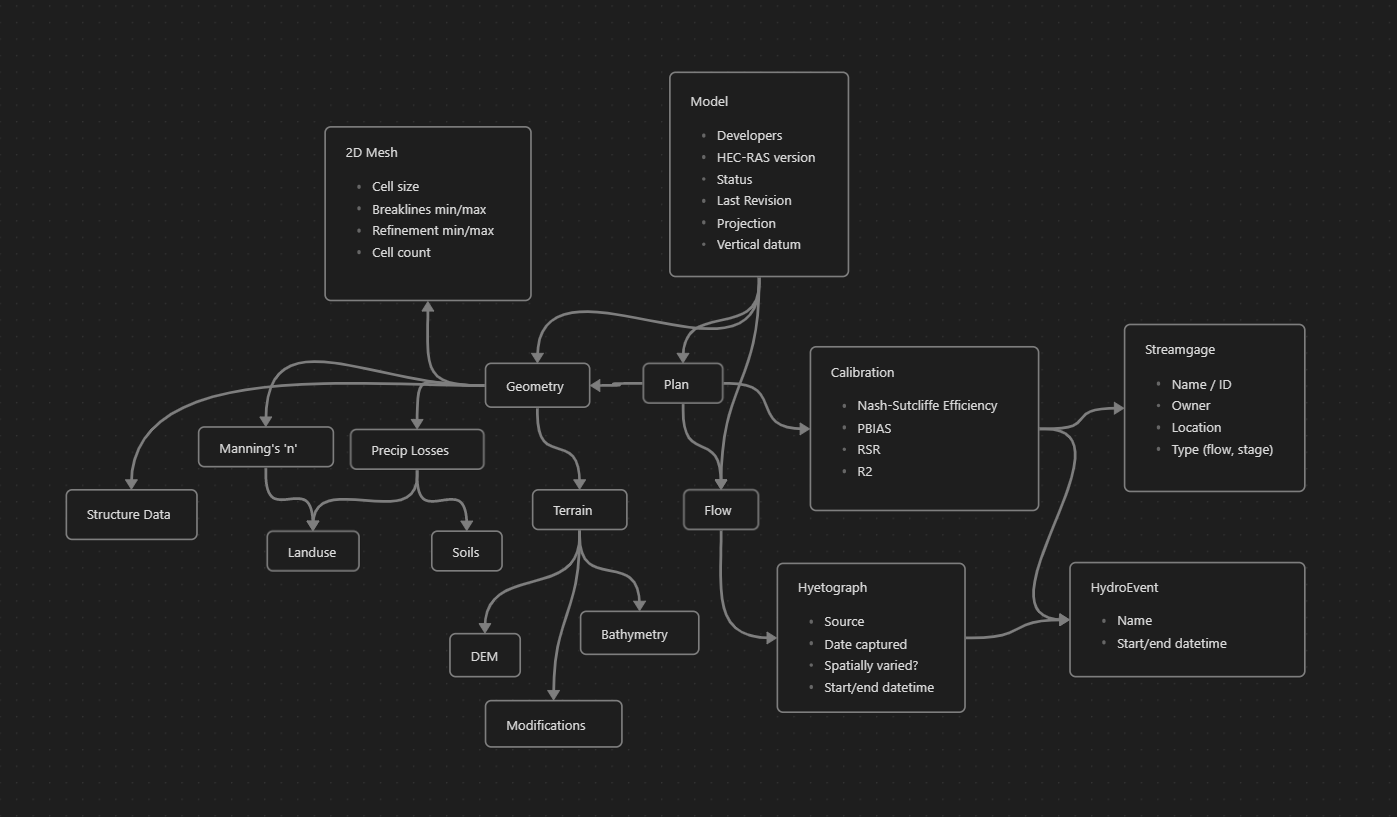

In [37]:
display(image)

In [38]:
ffrd = FFRDMeta()
g = rdflib.Graph()
g.parse("../kanawha/kanawha.ttl", format="turtle")

<Graph identifier=Nca92d15bea204090bc4d1c80945c7f00 (<class 'rdflib.graph.Graph'>)>

## Vocabularies 
An ontology provides a common vocabulary and a shared understanding of a domain, enabling systems to communicate with each other and reason about the domain.

The vocabularies listed below are used by RASCAT and in this notebook.

In [39]:
for item in g.namespaces():
    if item[0] in ffrd.vocabularies:
        ns, ref = item[0], item[1]
        gage_link = f'<b><a  href="{str(ref)}" target="_blank">{str(ns)}</a></b> &nbsp;&nbsp;{str(ref)}'
        display( HTML(gage_link))

## Namespaces 
A namespace is a way of organizing identifiers (such as variable names, function names, or class names) in a program or system to avoid naming conflicts. It provides a unique identifier for each entity to ensure that there are no naming clashes. In other words, a namespace is a container for a set of identifiers that are used to uniquely identify a specific resource or object. In this case, namespaces are customized to specify locations (i.e. in the cloud, on a server) where project/model specific data is located.

The example namespaces listed below were defined for the Kanawha project. These URLs do not presently resolve, but they serve as an example for how FFRD data could potentially be organized and linked.

In [40]:
for item in g.namespaces():
    if item[0] in ffrd.namespaces:
        ns, ref = item[0], item[1]
        gage_link = f'<b><a  href="{str(ref)}" target="_blank">{str(ns)}</a></b> &nbsp;&nbsp;{str(ref)}'
        display(HTML(gage_link))

In [41]:
image = Image(filename='imgs/graphdb.png')

## Linked Data Queries

Through the development of model-centric metadata development, graphs can be traversered from any starting node to any node in the graph.

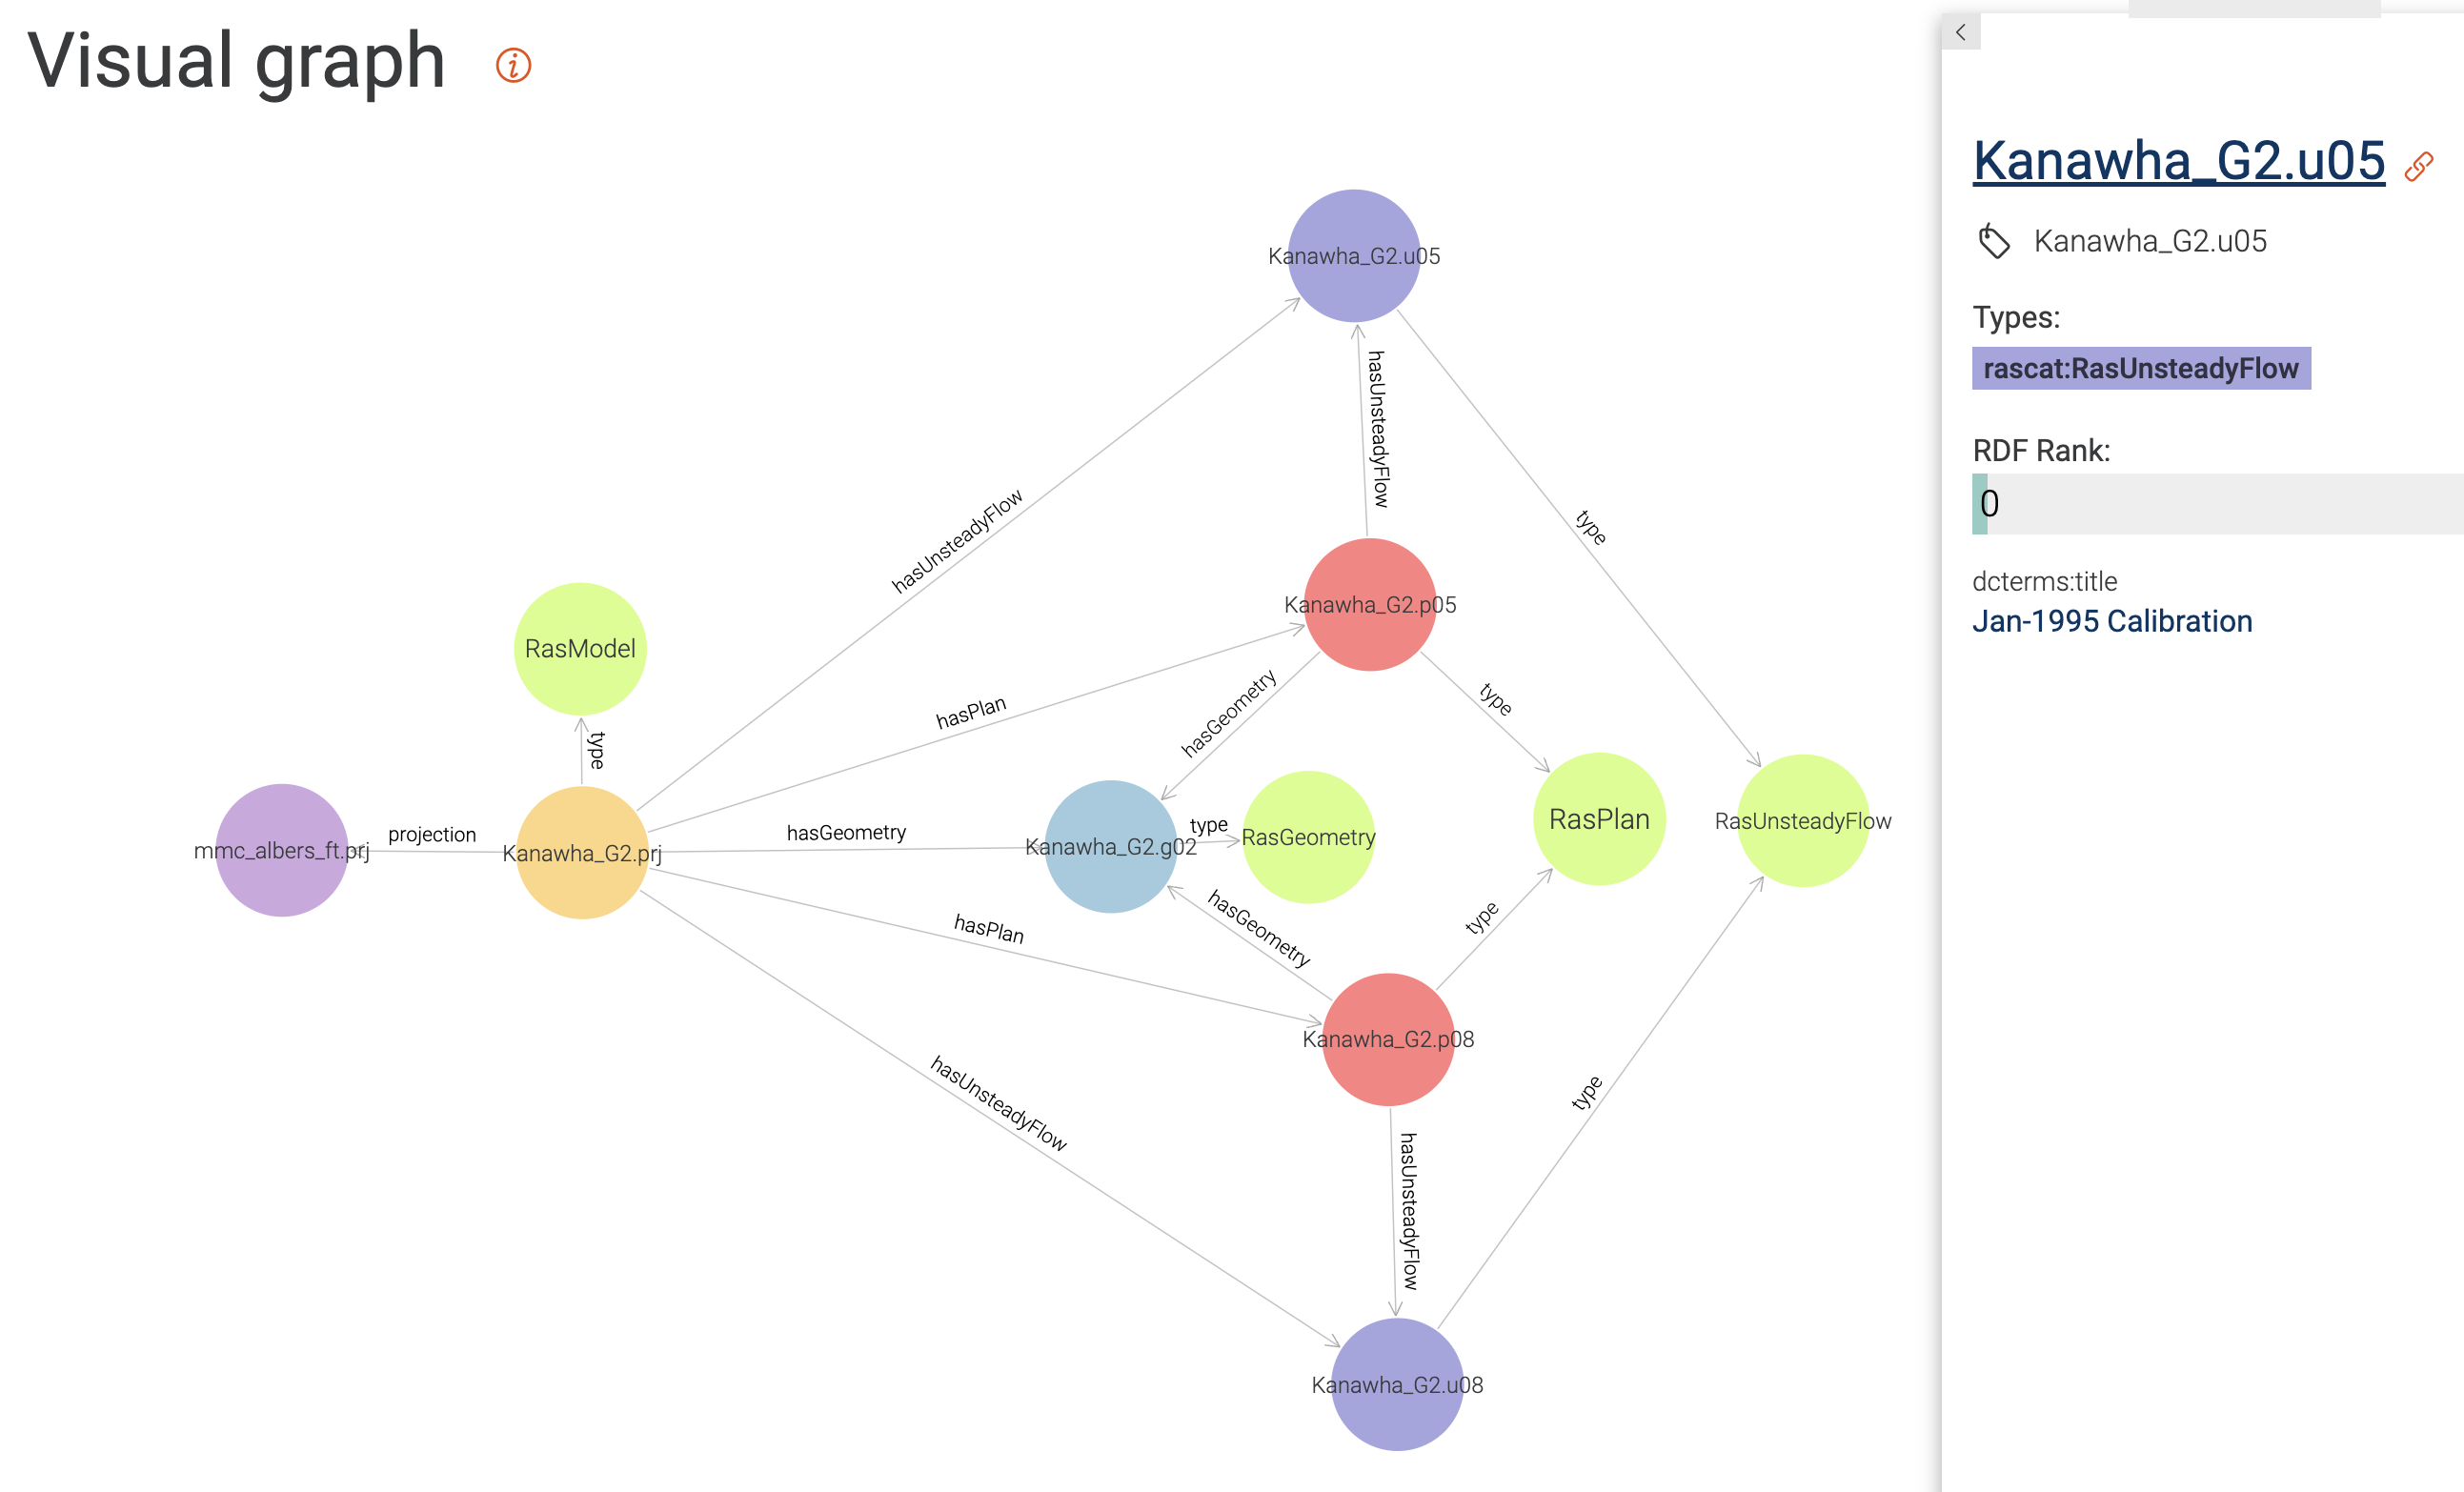

In [42]:
display(image)

The image above illustrates a subset of the Kanawha metadata. In this example, a HEC-RAS model called `Kanawha_G2.prj` is represented. This model is linked to a Geometry file, `Kanawha_G2.g02`, which is referenced by two different HEC-RAS Plan files: `Kanawha_G2.p05` and `Kanawha_G2.p08`. Plan `p05` has an Unsteady Flow file `Kanawha_G2.u05`, and Plan `p08` has an Unsteady Flow file `Kanawha_G2.u08`.

### Example Queries: Model Provenance

#### Find all models created by a certain engineer
Metadata links enable sophisticated (yet simple) queries to connect models with the firm that developed them, calibration events included in model setup and development, simulations in the various plans, etc. 

In this example, the Kanawha Metadata can be queried to identify the modeler of record.

In [43]:
model_creator = "Mark McBroom"

Results form a *creator query* pulling data from the Kanawha Metadata files:

In [44]:
models = dict()

for row in g.query(ffrd.query_creator(model_creator)):
    title = row[0]
    description = row[1]
    ras_model_path = row[2]
    models[title] = {"description":description, "model_location":ras_model_path}
    
display(stylized_json(models))

The query results show three models in the inventory developed by the creator used in the query. Results include description, and path to the model. As data is shipped to the cloud or incorporated in Model Library, these links will take users directly to the model.

#### Find all models created by a certain firm

This search could be expanded to look for models developed by a specific firm or PTS partner.

In [45]:
org_name = "Freese and Nichols"

In [46]:
projects = dict()

for row in g.query(ffrd.query_org(org_name)):
    title = row[0]
    description = row[1]
    ras_model_path = row[2]
    org_name = row[3]
    jv_name = row[4]
    
    projects[title] = { "PTS":jv_name,"firm":org_name, "description":description, "model_location":ras_model_path}
        
display(stylized_json(projects))

### Example Queries: Model Geometry

The `rascat` vocabulary incorporates qualitative and quantitative data. The following example searches the inventory of ras models developed for the Kanawha study to identify geometries with large meshes (i.e. high cell counts) and return the path to the file, the cell count, and descriptions of the model.

In [47]:
cell_count = 400000

In [48]:
large_meshes = dict()

for row in g.query(ffrd.query_cell_count(cell_count)):
    title = row[0]
    description = row[1]
    model = row[2]
    geometry = row[3]
    cell_count = row[4]
    large_meshes[title] = {"geometry":geometry, "description":description, "cell_count":int(cell_count)}

display(stylized_json(large_meshes))

Note: Metadata checks may also enabled prior to submission or scaling. In the above list of models returned from the query, several models do not include descriptions. Metadata checks put in place prior to scaling (i.e. running 1,000's of probabilistic simulations in the cloud) would identify elements needing completion/additional information, ensuring consistent, quality deliverables.

### Example Queries: Source Data

There are numerous scenarios in which it may be required to evaluate the foundational data used in the development of models. Examples include topography, presence or absence of hydraulic structures, impervious surface cover to name a few.

This example performs a search on the landuse/landcover sources used to develop surface soughness parameters in models included in the inventory.


In [49]:
# lulc_datasets = {}
lulc_datasets = []

for row in g.query(ffrd.query_lulc()):
    lulc_desc = row[0]
    titles = str(row[1]).split(",")
    lulc_title = row[2]
    # lulc_datasets[lulc_desc] = [t.strip() for t in titles]
    landuse_dataset = {
        "title": lulc_title,
        "description": lulc_desc,
        "models": [t.strip() for t in titles]
    }
    lulc_datasets.append(landuse_dataset)
    
display(stylized_json(lulc_datasets))

Results show that three land cover datasets were shared by multiple models. The metadata could be further queried to identify scripts or processes used to develop the datasets where inclduded.

###  Example Queries: USGS Gages
Another application of metadata queries would be identification of USGS gages associated with HEC-RAS models. This search identifies the models which include simulations or calibration events at a gage location.

In [50]:
gage = "03187500"

In [51]:
for row in g.query(ffrd.query_gage(gage)):
    model = row[0]
    print(model)

http://example.ffrd.fema.gov/kanawha/models/GSummersville_B.prj
http://example.ffrd.fema.gov/kanawha/models/GSummersville_C.prj


Due to the bi-drectional nature of the data in the Kanawha metadata, the inverse approach can be taken: search models to identify the presence of gages in plans.


In [52]:
model = "New-LittleRiver.prj"

In [53]:
gage_urls = dict()

for row in g.query(ffrd.query_gages(model)):
    model = row[0]
    gage = row[1]
    gageID = row[2]
    gage_link = f'<a href="{str(gage)}">USGS {str(gageID)}</a>'
    gage_urls[gage_link] = str(model)

display(stylized_json(gage_urls))

### Example Queries: Calibration

Models calibrated prior to probabilistic simulations will include additional information useful for QAQC prior to scaling. In this example, a metadata query searches the calibration events in a model and returns the results of the Nash-Sutcliffe Efficiency metric for the top three poorest performing locations.

In [54]:
calibration_events = dict()

for row in g.query(ffrd.query_calibration(limit=3)):
    title = row[0]
    description = row[1]
    model = row[2]
    flow = row[3]
    gage = row[4]
    nse = row[5]
    flow_title = row[6]
    gage_title = row[7]
    hydro_type = row[8]
    plan = row[9]
    plan_title = row[10]
    if calibration_events.get(str(title)) is None:
        calibration_events[str(title)] = dict()

    calibration_events[str(title)][gage_title] = {
        "plan": plan_title,
        "Nash-Sutcliffe Efficiency score": nse,
        "observation": hydro_type,
        "gage_link": gage
    }
    
display(stylized_json(calibration_events))

In [55]:
model = "CoalRiver.prj"
gage_urls = []
models = []

for row in g.query(ffrd.query_usgs_gages()):
    model = row[0]
    gage = row[1]
    gage_urls.append(gage)
    gageID = row[2]
    models.append(model)

gage_ld_jsons = []
for gage_url in gage_urls:
    gage_ld_jsons.append(get_ld_json(gage_url))

http://example.ffrd.fema.gov/kanawha/models/BasinG6.prj https://waterdata.usgs.gov/monitoring-location/03182888 03182888
http://example.ffrd.fema.gov/kanawha/models/BluestoneLocal.prj https://waterdata.usgs.gov/monitoring-location/03179800 03179800
http://example.ffrd.fema.gov/kanawha/models/BluestoneLocal.prj https://waterdata.usgs.gov/monitoring-location/03177120 03177120
http://example.ffrd.fema.gov/kanawha/models/Bluestone_Upper.prj https://waterdata.usgs.gov/monitoring-location/03177710 03177710
http://example.ffrd.fema.gov/kanawha/models/Bluestone_Upper.prj https://waterdata.usgs.gov/monitoring-location/03179000 03179000
http://example.ffrd.fema.gov/kanawha/models/CoalRiver.prj https://waterdata.usgs.gov/monitoring-location/03198350 03198350
http://example.ffrd.fema.gov/kanawha/models/CoalRiver.prj https://waterdata.usgs.gov/monitoring-location/03198500 03198500
http://example.ffrd.fema.gov/kanawha/models/CoalRiver.prj https://waterdata.usgs.gov/monitoring-location/03200500 03200

### Example Queries: Geospatial

Geospatial search and discovery is enabled through linked data provided by the `rascat` ontology using the same approach as the USGS for gage locations. A linked data search of the USGS gages identified in the Kanawha metadata can be used to fetch information from the USGS gage website directly, as shown in the map below.

In [56]:
center_lat = statistics.mean([float(i['geo']['latitude']) for i in gage_ld_jsons])
center_lng = statistics.mean([float(i['geo']['longitude']) for i in gage_ld_jsons])

center = (center_lat, center_lng)

m = folium.Map(location=center, zoom_start=8)

for idx, j in enumerate(gage_ld_jsons):
    location = [float(j['geo']['latitude']), float(j['geo']['longitude'])]
    name = j['name']
    description = j['description']
    gage_url = j['@id']
    model = models[idx]
    popup_content = f"""<h3>{name}</h3><p>Calibration gage for model: <b>{model}</b></p><h4>Gage info pulled from USGS linked data:</h4><p><b>Location:</b> {str(location)}</p><p><b>Description:</b> {description}</p><p><a target="_blank" rel="noopener noreferrer" href="{gage_url}">{gage_url}</a></p>"""
    popup = Popup(popup_content, max_width=2650)
    marker = Marker(location=location, draggable=False, title=name, popup=popup)
    m.add_child(marker)
m

The above example is facilitated by linked data in JSON-LD format embedded within USGS gage pages. As shown in the json below, the use of linked data enables interoperability and data exchange seamlessly between FEMA models and USGS observations.**

In [57]:
display(stylized_json(gage_ld_jsons[0]))

### Example Queries: Stochastic Storm Transposition Library
Because the metadata for the Kanawha project includes machine-readable information, it can be used to query the Stochastic Storm Transposition (SST) library to identify precipitation datasets for the storms used in the models. The SST database is a collection of many storms that can be used to develop probabilistic simulations. This can be used to recreate the precipitation datasets used in the models, or to identify additional storms that may be useful for future model development.

The following are the `HydroEvent`s in the Kanawha metadata - the storms which were used for calibrating the HEC-RAS models.

In [58]:
from datetime import datetime

hydroevents = {}
for row in g.query(ffrd.query_hydroevents()):
    url = row[0]
    storm = url.split("/")[-1]
    start_dt = row[1]
    end_dt = row[2]
    hydroevents[storm] = {
        "start": start_dt,
        "end": end_dt
    }
display(stylized_json(hydroevents))

Now, using the above information to query the SST library for datasets pertaining to the June 2016 storm:

In [ ]:
start_dt = datetime.fromisoformat(hydroevents["Jun2016"]["start"])
end_dt = datetime.fromisoformat(hydroevents["Jun2016"]["end"])

In [59]:
g_aorc = rdflib.Graph()
g_aorc.parse("https://ckan.dewberryanalytics.com/dataset/9b08c661-3b9c-441f-a4a0-6e1a9c865475/resource/16212ad7-32f9-49c4-b78e-d136bc1425d5/download/2016.jsonld", format="json-ld")
sst_results = g_aorc.query(ffrd.query_sst())

sst_dss = []
for row in sst_results:
    dist = row[0]
    url = row[1]
    temporal = row[2]
    temporal_dt = datetime.fromisoformat(temporal.split("/")[0])
    if temporal_dt >= start_dt and temporal_dt <= end_dt:
        sst_dss.append(url)
display(stylized_json(sst_dss))

## Conclusion
The example queries above demonstrate that a knowledge graph is a powerful structure for organizing metadata and cataloging datasets such as HEC-RAS models. The concepts and technologies developed around the Semantic Web allow for machine-traversable connections between disparate data elements. As FEMA moves toward the Future of Flood Risk Data, the PTS team recommends the agency strongly consider the use of linked data and ontologies to organize and share flood models and related datasets.